In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib import location
import scienceplots
plt.style.use(["science", "notebook"])

## Data intake

In [27]:
ceda = pd.read_pickle("CEDA_dataNL.pickle")
# openmeteo = pd.read_pickle("Data/openmeteo.pickle")
pvgis = pd.read_pickle('Data/Sites/PVGIS_2.pkl')

prod_NL = pd.read_pickle("Data/Sites/PV_2.pkl")
meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation": "downward_surface_SW_flux",
              "diffuse_radiation":"diffuse_surface_SW_flux",
              "direct_normal_irradiance":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
# openmeteo = openmeteo.rename(columns=meteo2CEDA)
variates = list(ceda.columns)
rows = int(np.ceil(np.sqrt(len(variates))))

In [10]:
power = pd.read_pickle("Data/Sites/PV_2.pkl")

## Historic plot

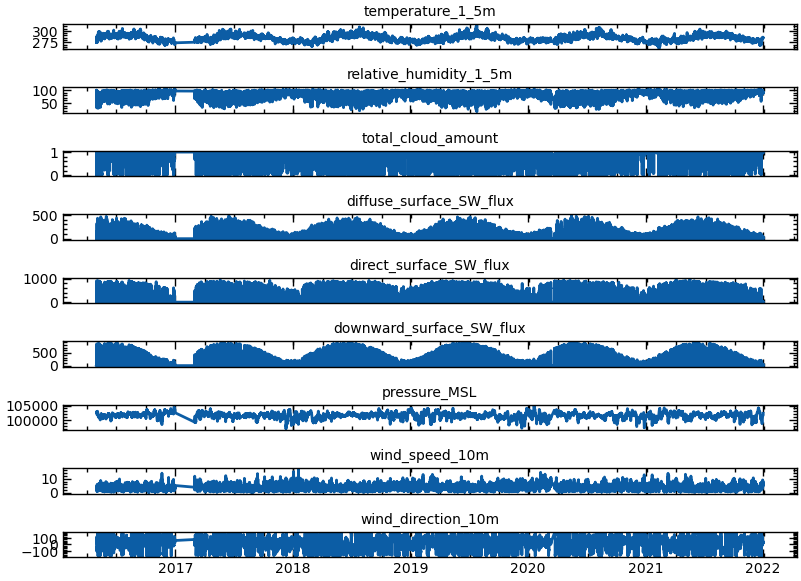

In [5]:
fig, axs = plt.subplots(len(variates), sharex=True)
plt.tight_layout()
for i, var in enumerate(variates):
    axs[i].plot(ceda[var])
    axs[i].set_title(var, fontsize = 10)
    axs[i].tick_params(labelsize=10)
plt.show()


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


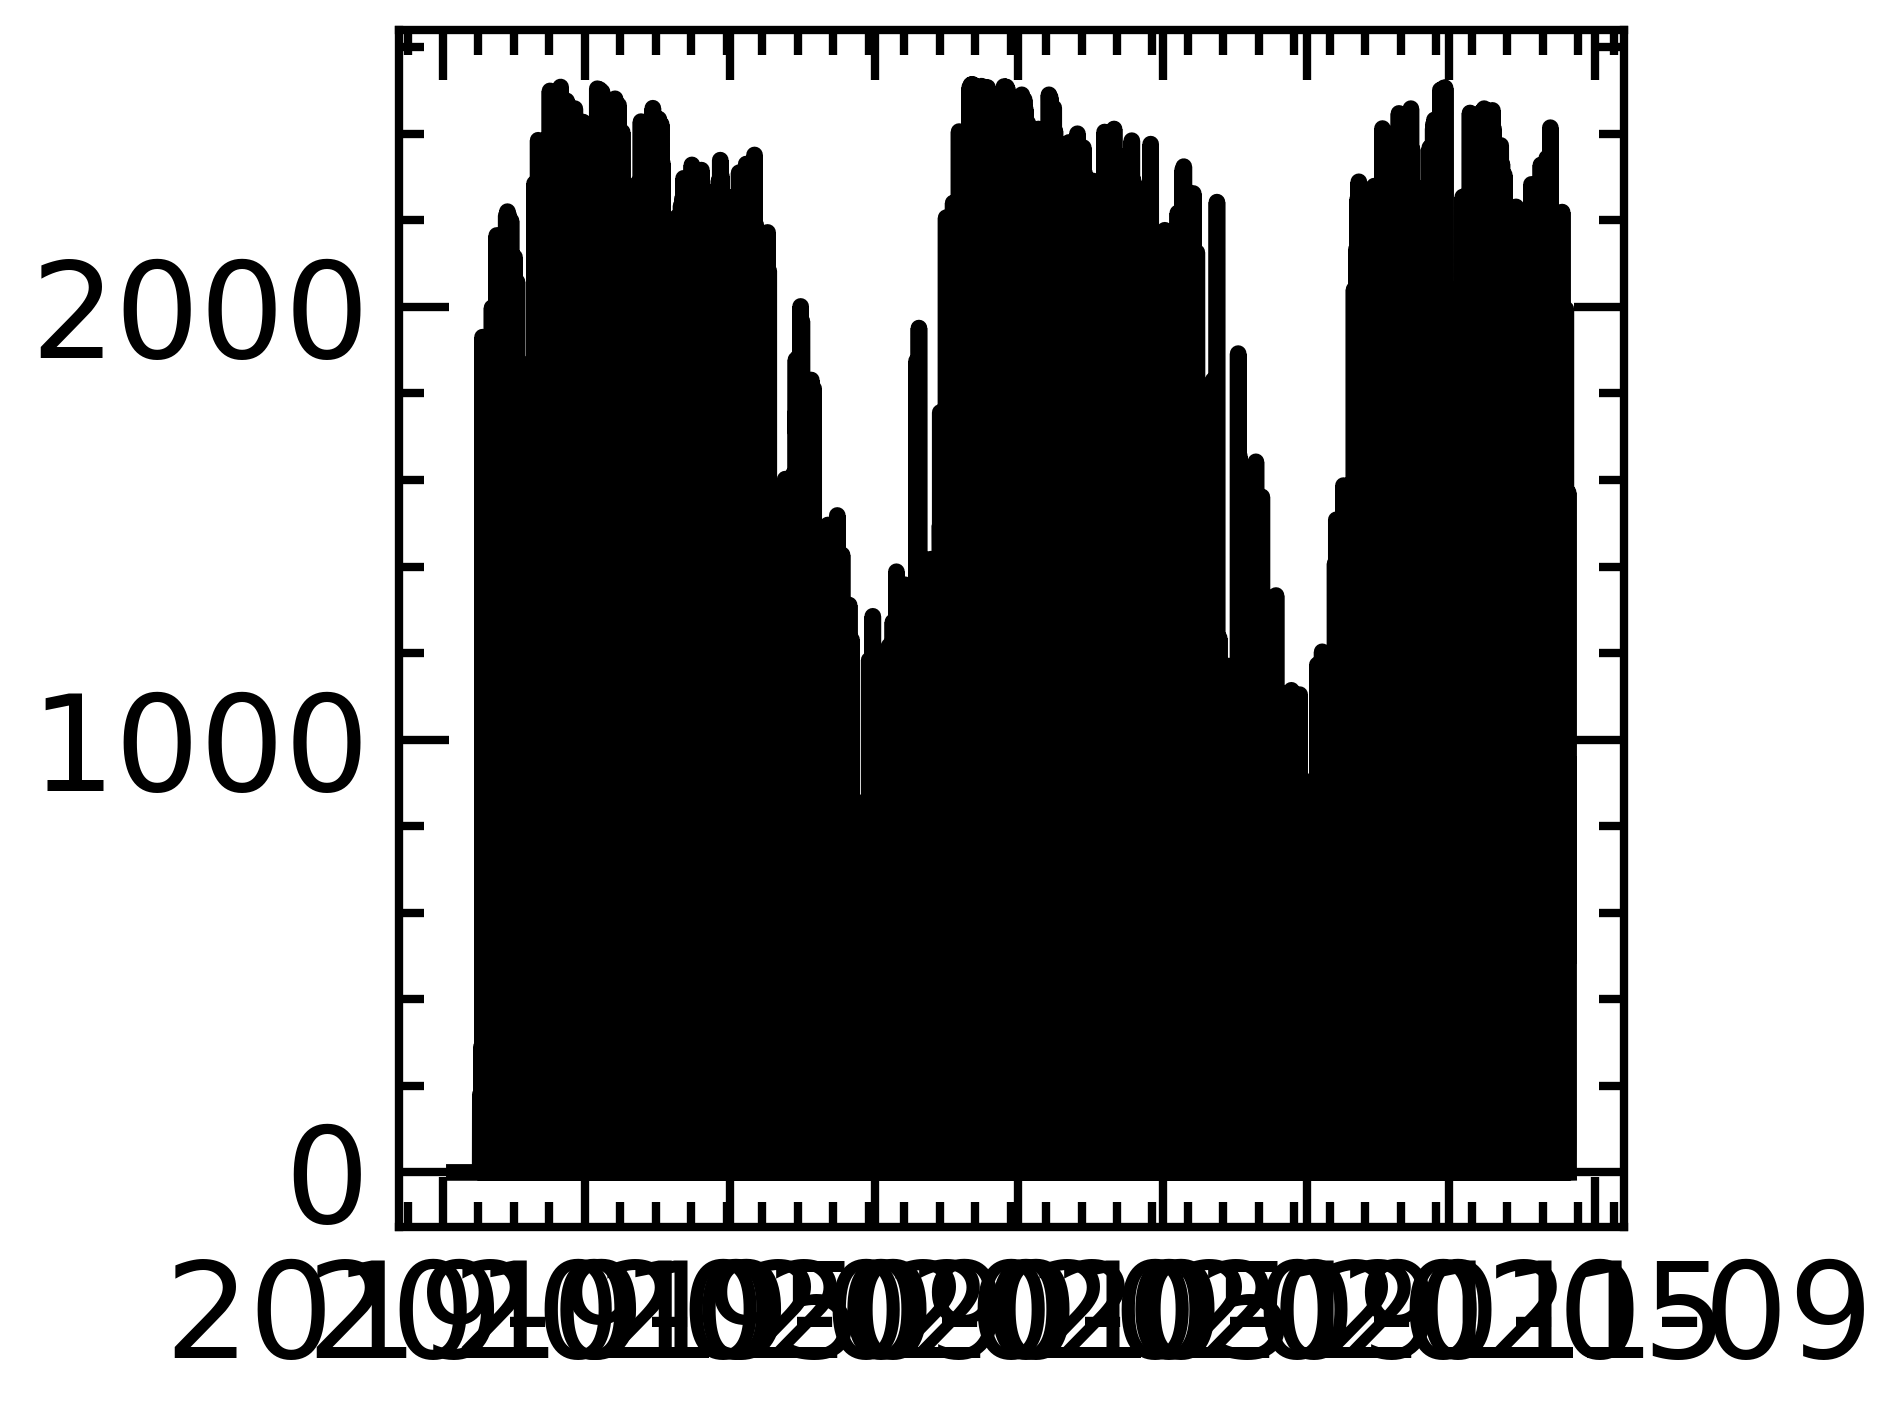

In [66]:
plt.plot(prod_NL)
plt.tight_layout()

## Histograms

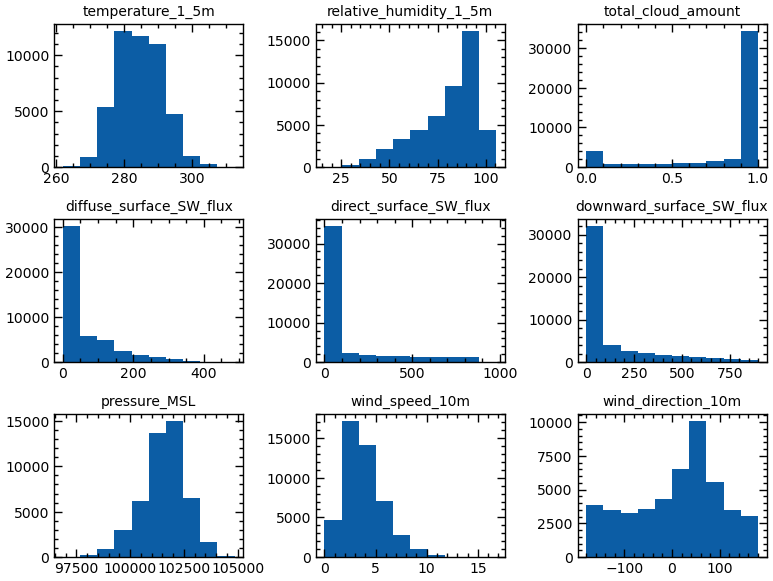

In [7]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## Correlation: CEDA & PROD_NL 

Here add still correlation with transformed variables


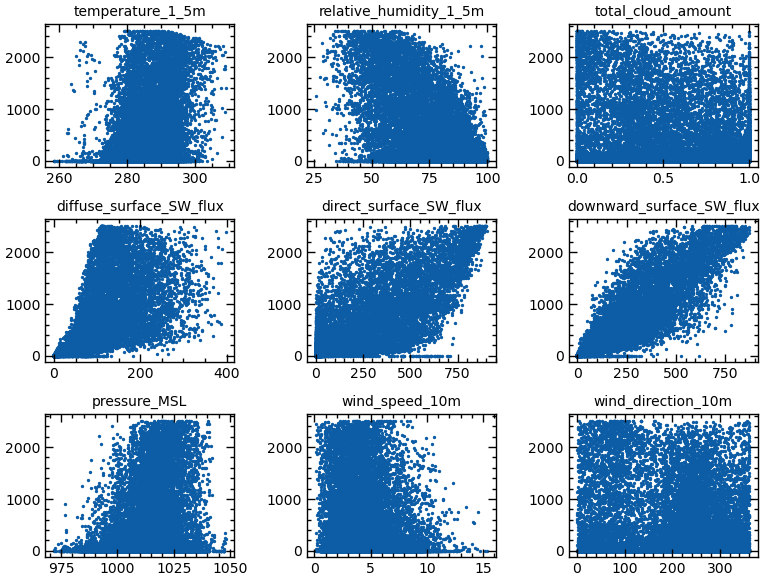

In [5]:
correl = pd.merge(prod_NL, ceda, right_index=True, left_index=True)
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter( correl[var],correl ['P'],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

C:\Users\Robbe\AppData\Local\Temp\ipykernel_6888\2427408902.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


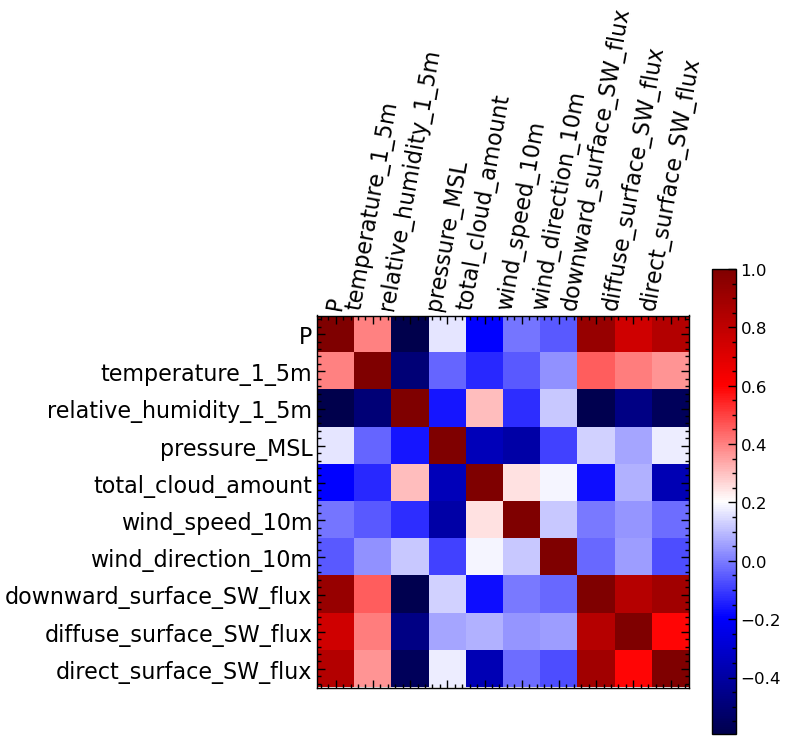

In [6]:
axs = plt.matshow(correl.corr(), cmap='seismic')
plt.xticks(ticks=range(10), labels=list(correl.columns), rotation= 80)
plt.yticks(ticks=range(10), labels = list(correl.columns), rotation= 0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## CEDA VS OPENMETEO

In [10]:
openmeteo = openmeteo.reindex(ceda.index)

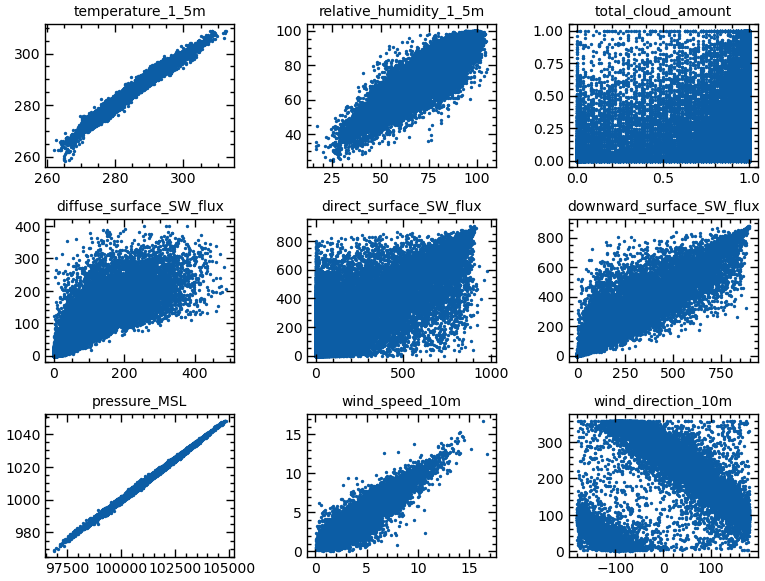

In [11]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter(ceda[var], openmeteo[var],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

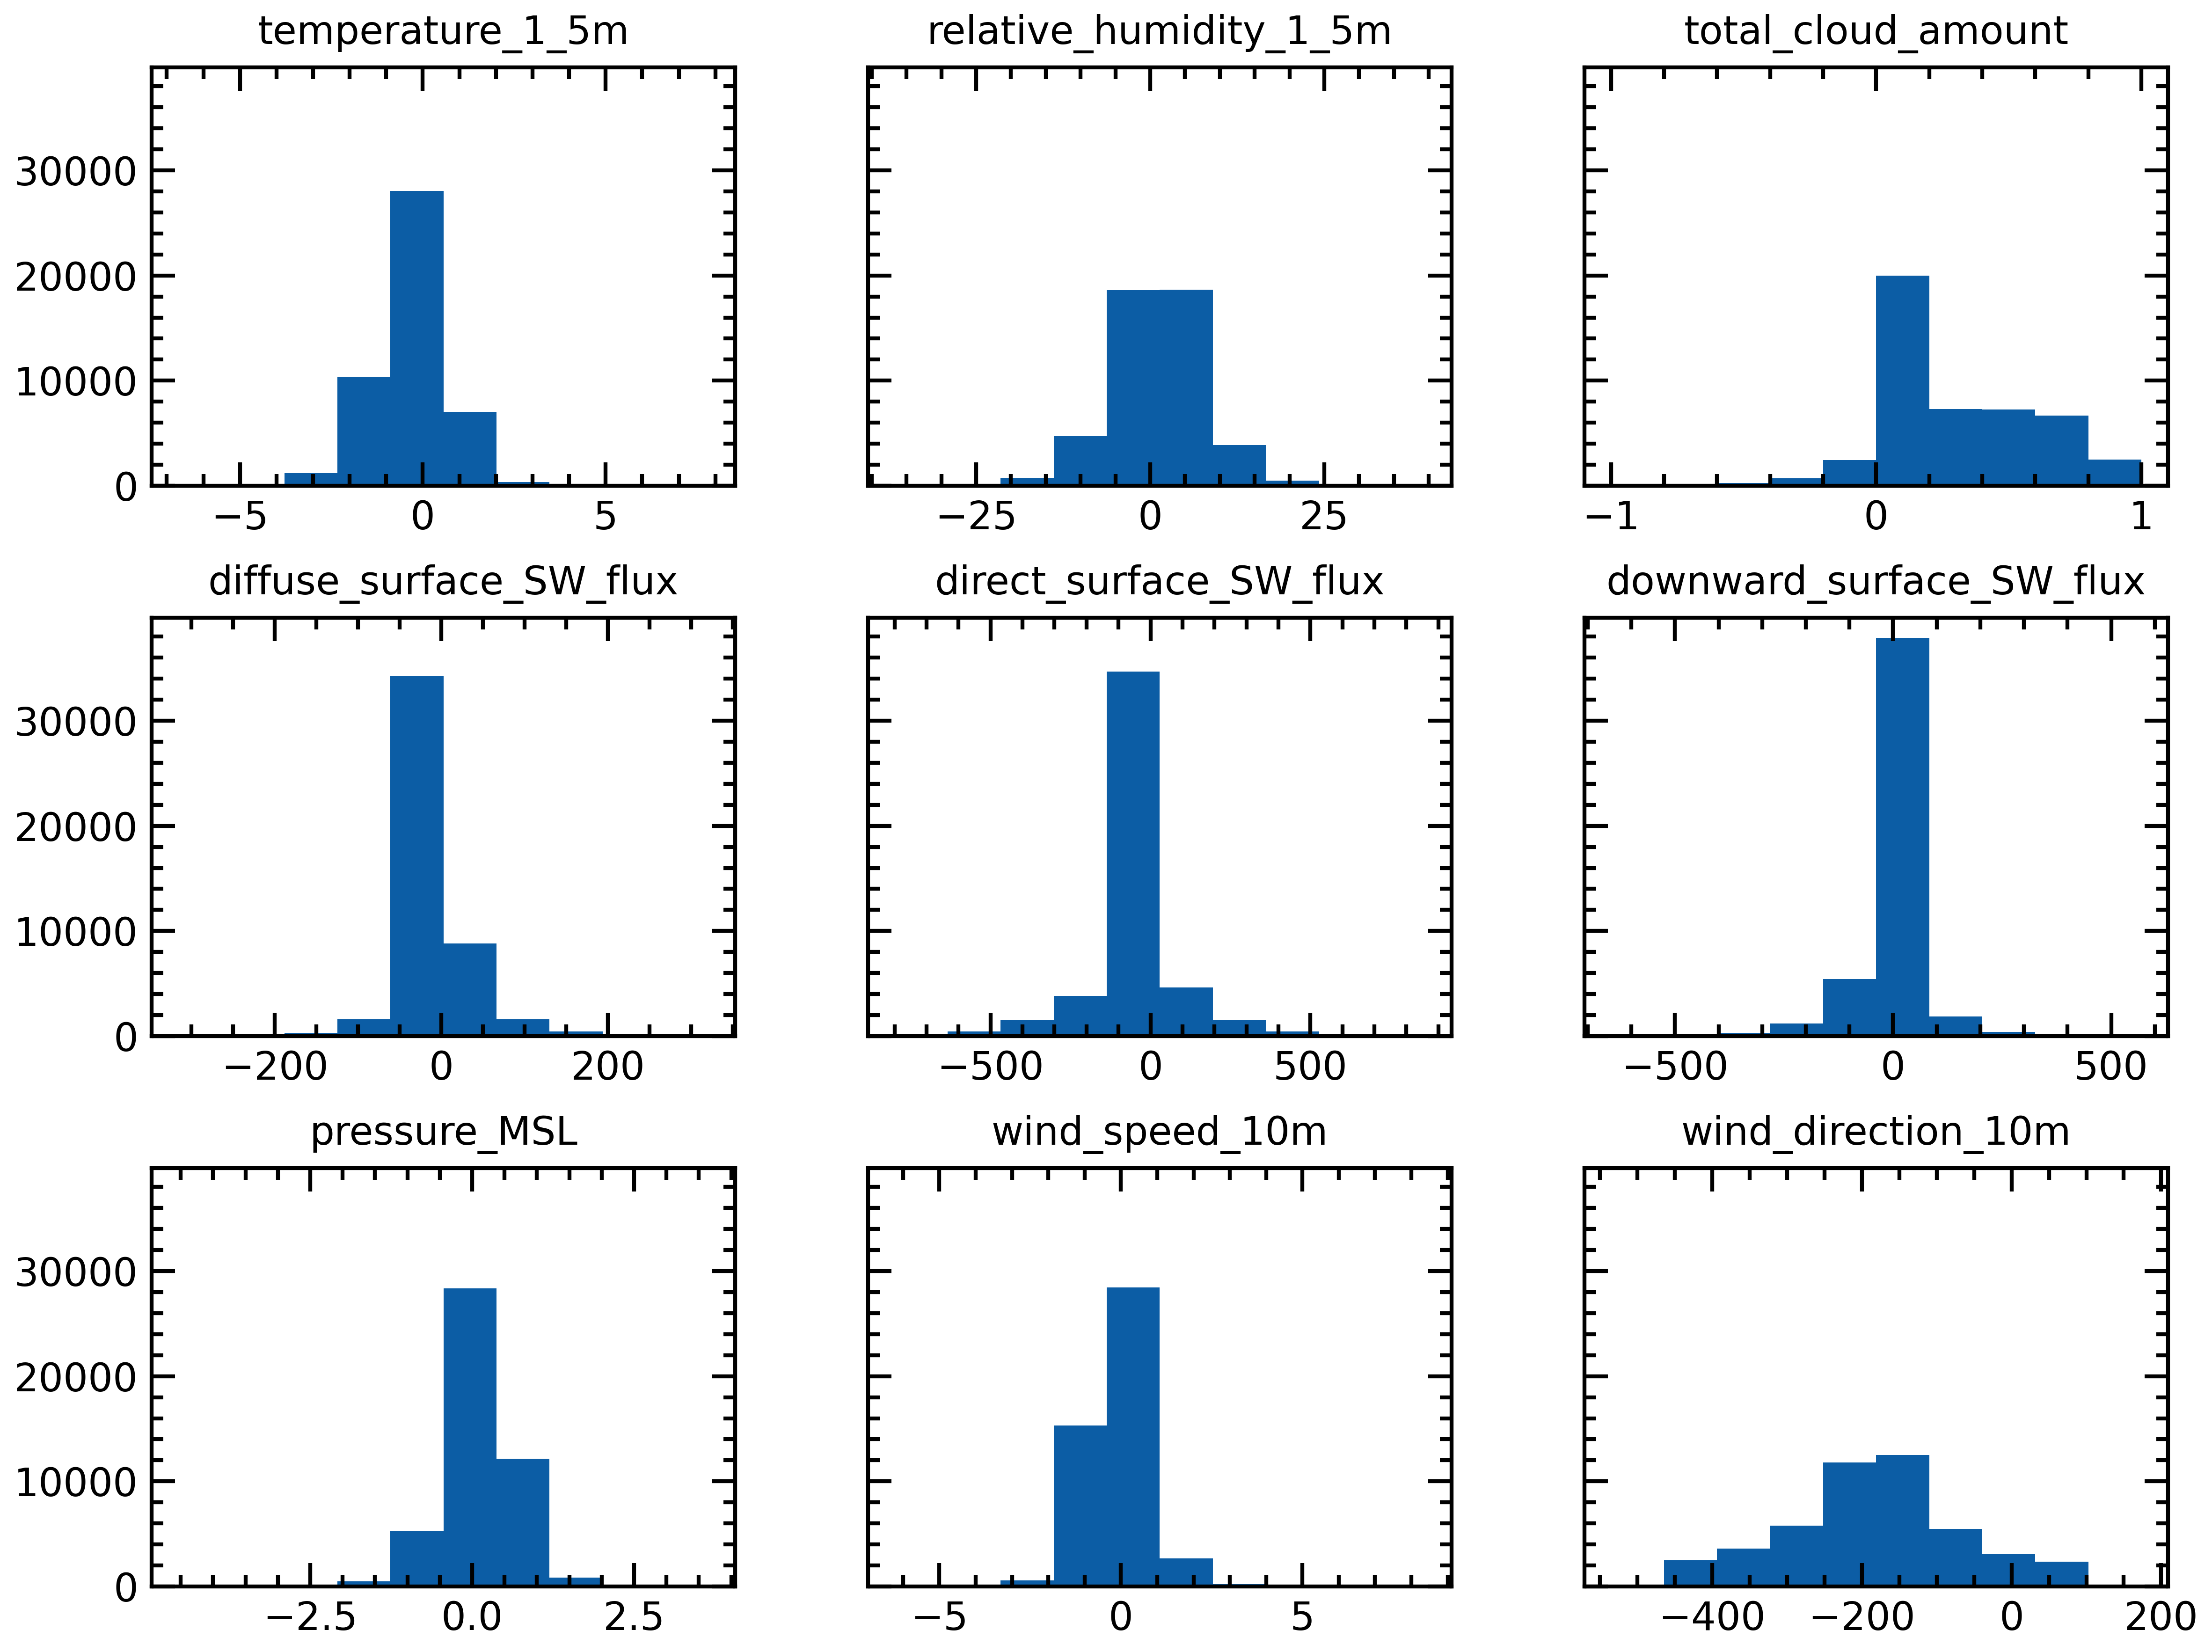

In [70]:
fig, axs = plt.subplots(rows, rows, sharey=True)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var]-openmeteo[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## PROD_NL VS PVGIS

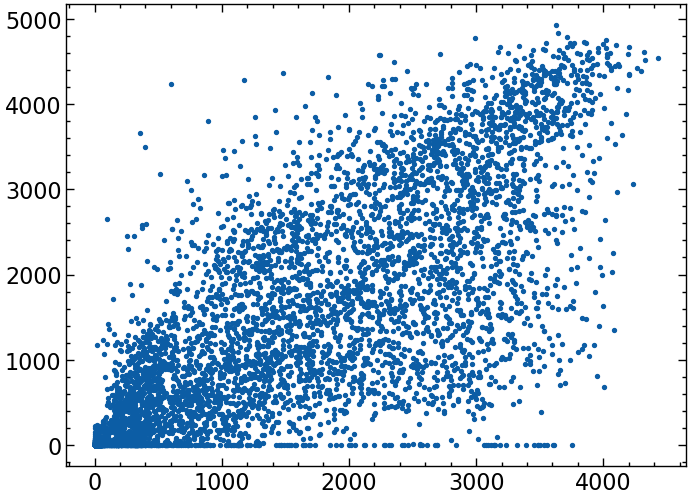

In [28]:
powers= pd.merge(pvgis, prod_NL, left_index=True, right_index=True)
plt.scatter(powers['P_x'], powers['P_y'], s=8)

In [29]:
powers.corr()

,P_x,P_y
P_x,1.000000,0.854722
P_y,0.854722,1.000000


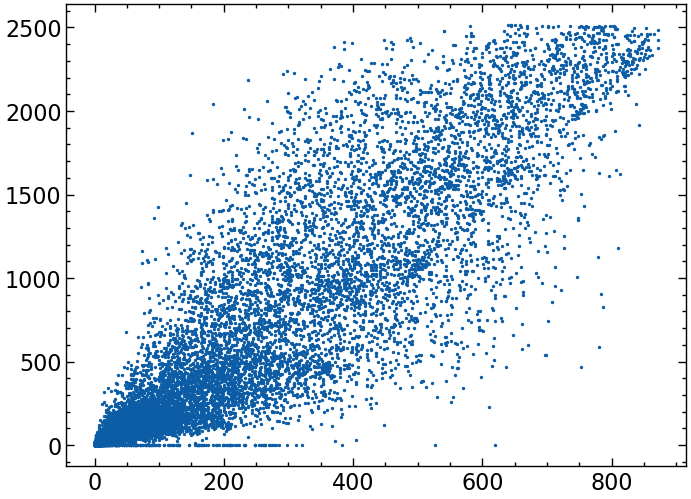

In [4]:
debug = pd.merge(openmeteo, prod_NL, left_index=True, right_index=True)
plt.scatter(debug['downward_surface_SW_flux'], debug['P'], s=2)

## Irradiance forecast errors grouped by solar zenith angle

In [82]:
irradiances_forecast = ceda[['downward_surface_SW_flux', 'direct_surface_SW_flux', "diffuse_surface_SW_flux"]]
irradiances_truth = openmeteo[['downward_surface_SW_flux', 'direct_surface_SW_flux', "diffuse_surface_SW_flux"]]
latitude,longitude = 52.0499, 5.07391
site = location.Location(latitude, longitude, tz='UTC')
times = irradiances_forecast.index
solar_pos = site.get_solarposition(times)
print(solar_pos)
zenith = np.deg2rad(solar_pos['apparent_zenith'])
cos_zenith = np.cos(zenith)
error = pd.DataFrame(irradiances_forecast - irradiances_truth)
error['cos_zenith'] = cos_zenith
bins = np.arange(0, 1.1, 0.1)

# Group by custom bins for solar zenith angle
error['cos_zenith_interval'] = pd.cut(error['cos_zenith'], bins=bins)

mean_list = []
rmse_list = []
grouped = error.groupby('cos_zenith_interval')
for error_column in error.columns:
    if error_column != 'cos_zenith' and error_column != 'cos_zenith_interval':
    
        mean = grouped[error_column].mean()
    
        rmse = np.sqrt(grouped[error_column].apply(lambda x: np.mean(x**2)))
    
        # Rename the series with the error column name
        mean.name = error_column + '_' + 'mean'
        rmse.name = error_column + '_' + 'rmse'

        # Append to the results list
        mean_list.append(mean)
        rmse_list .append(rmse)

# Concatenate the results into a DataFrame
mean_df = pd.concat(mean_list, axis=1).reset_index()
rmse_df = pd.concat(rmse_list, axis=1).reset_index()




                           apparent_zenith      zenith  apparent_elevation  \
2016-05-01 00:00:00+00:00       112.622981  112.622981          -22.622981   
2016-05-01 01:00:00+00:00       110.414493  110.414493          -20.414493   
2016-05-01 02:00:00+00:00       105.970273  105.970273          -15.970273   
2016-05-01 03:00:00+00:00        99.710353   99.710353           -9.710353   
2016-05-01 04:00:00+00:00        92.100031   92.100031           -2.100031   
...                                    ...         ...                 ...   
2021-12-31 19:00:00+00:00       119.696697  119.696697          -29.696697   
2021-12-31 20:00:00+00:00       128.845888  128.845888          -38.845888   
2021-12-31 21:00:00+00:00       137.506183  137.506183          -47.506183   
2021-12-31 22:00:00+00:00       144.912271  144.912271          -54.912271   
2021-12-31 23:00:00+00:00       149.823465  149.823465          -59.823465   

                           elevation     azimuth  equation_of_t

C:\Users\Robbe\AppData\Local\Temp\ipykernel_6888\3096072424.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = error.groupby('cos_zenith_interval')


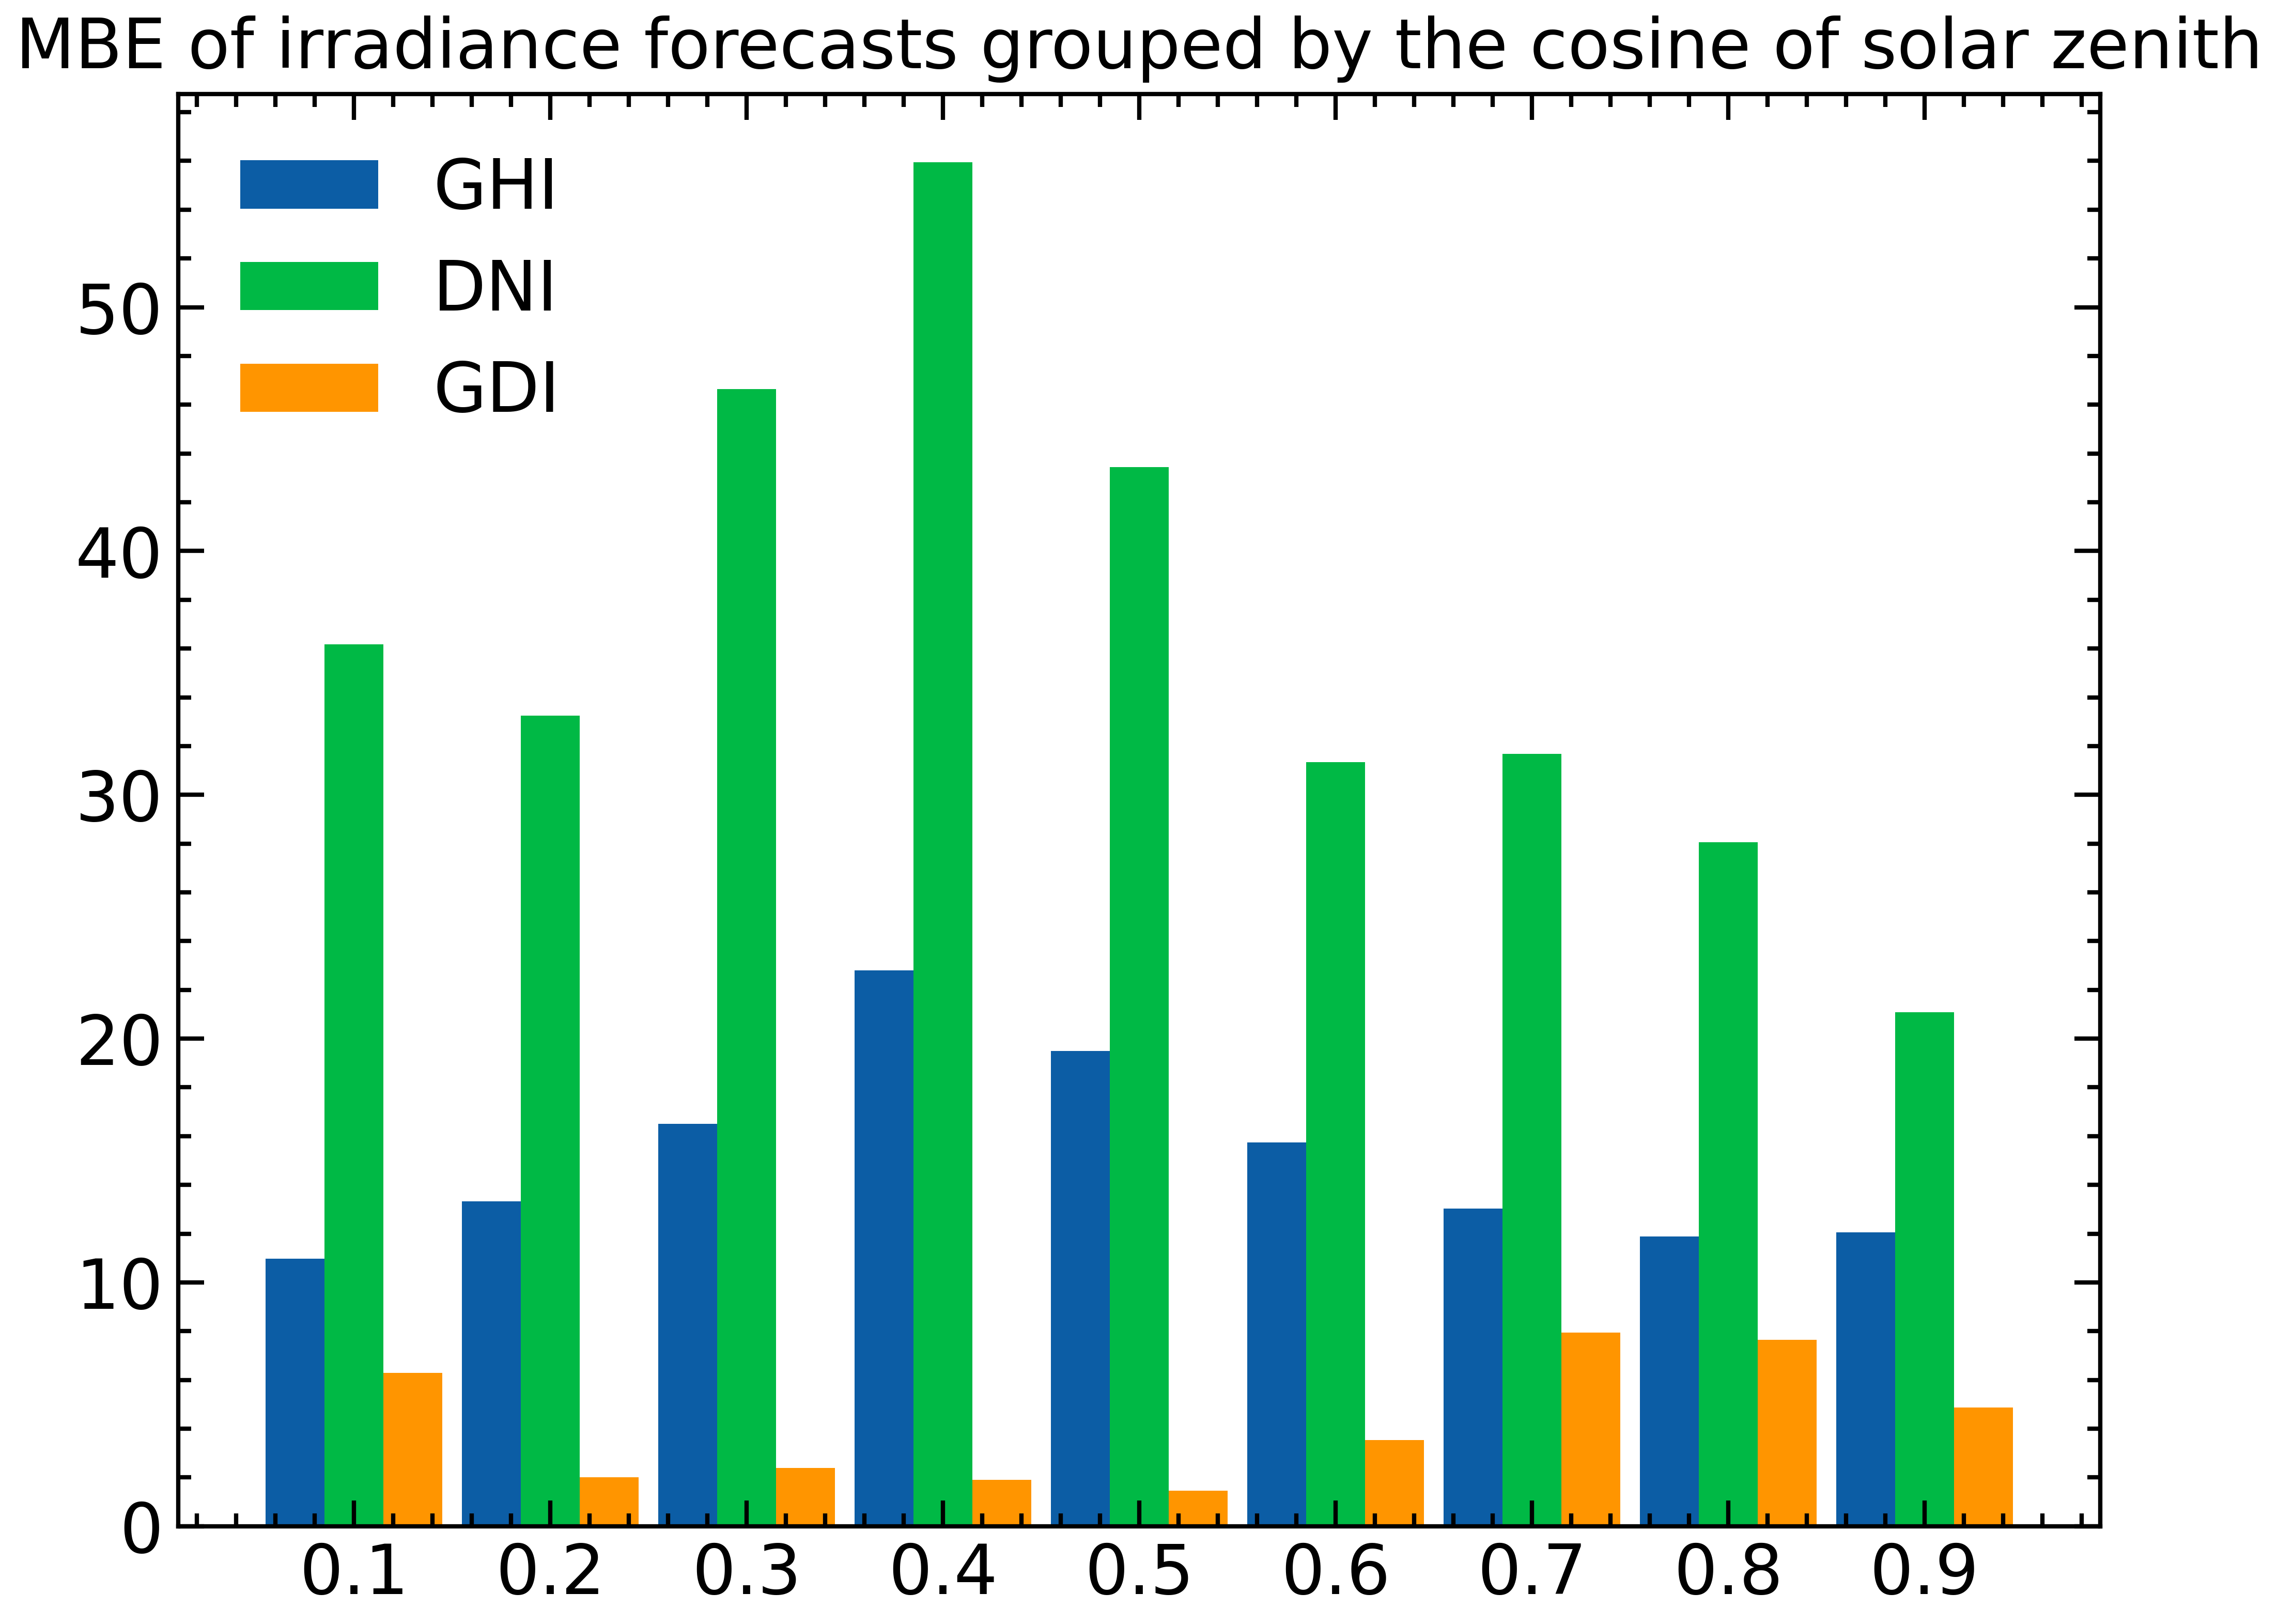

In [90]:
plt.figure()
x_axis = np.arange(len(mean_df.index))
plt.bar(x_axis-0.3, abs(mean_df["downward_surface_SW_flux_mean"]), 0.3, label = "GHI")
plt.bar(x_axis, abs(mean_df["direct_surface_SW_flux_mean"]), 0.3, label = "DNI")
plt.bar(x_axis+0.3, abs(mean_df["diffuse_surface_SW_flux_mean"]), 0.3, label = "GDI")
plt.title('MBE of irradiance forecasts grouped by the cosine of solar zenith')
plt.xticks(ticks = range(len(mean_df.index)-1), labels = [x/10 for x in range(1, 10)])

plt.legend()
plt.show()

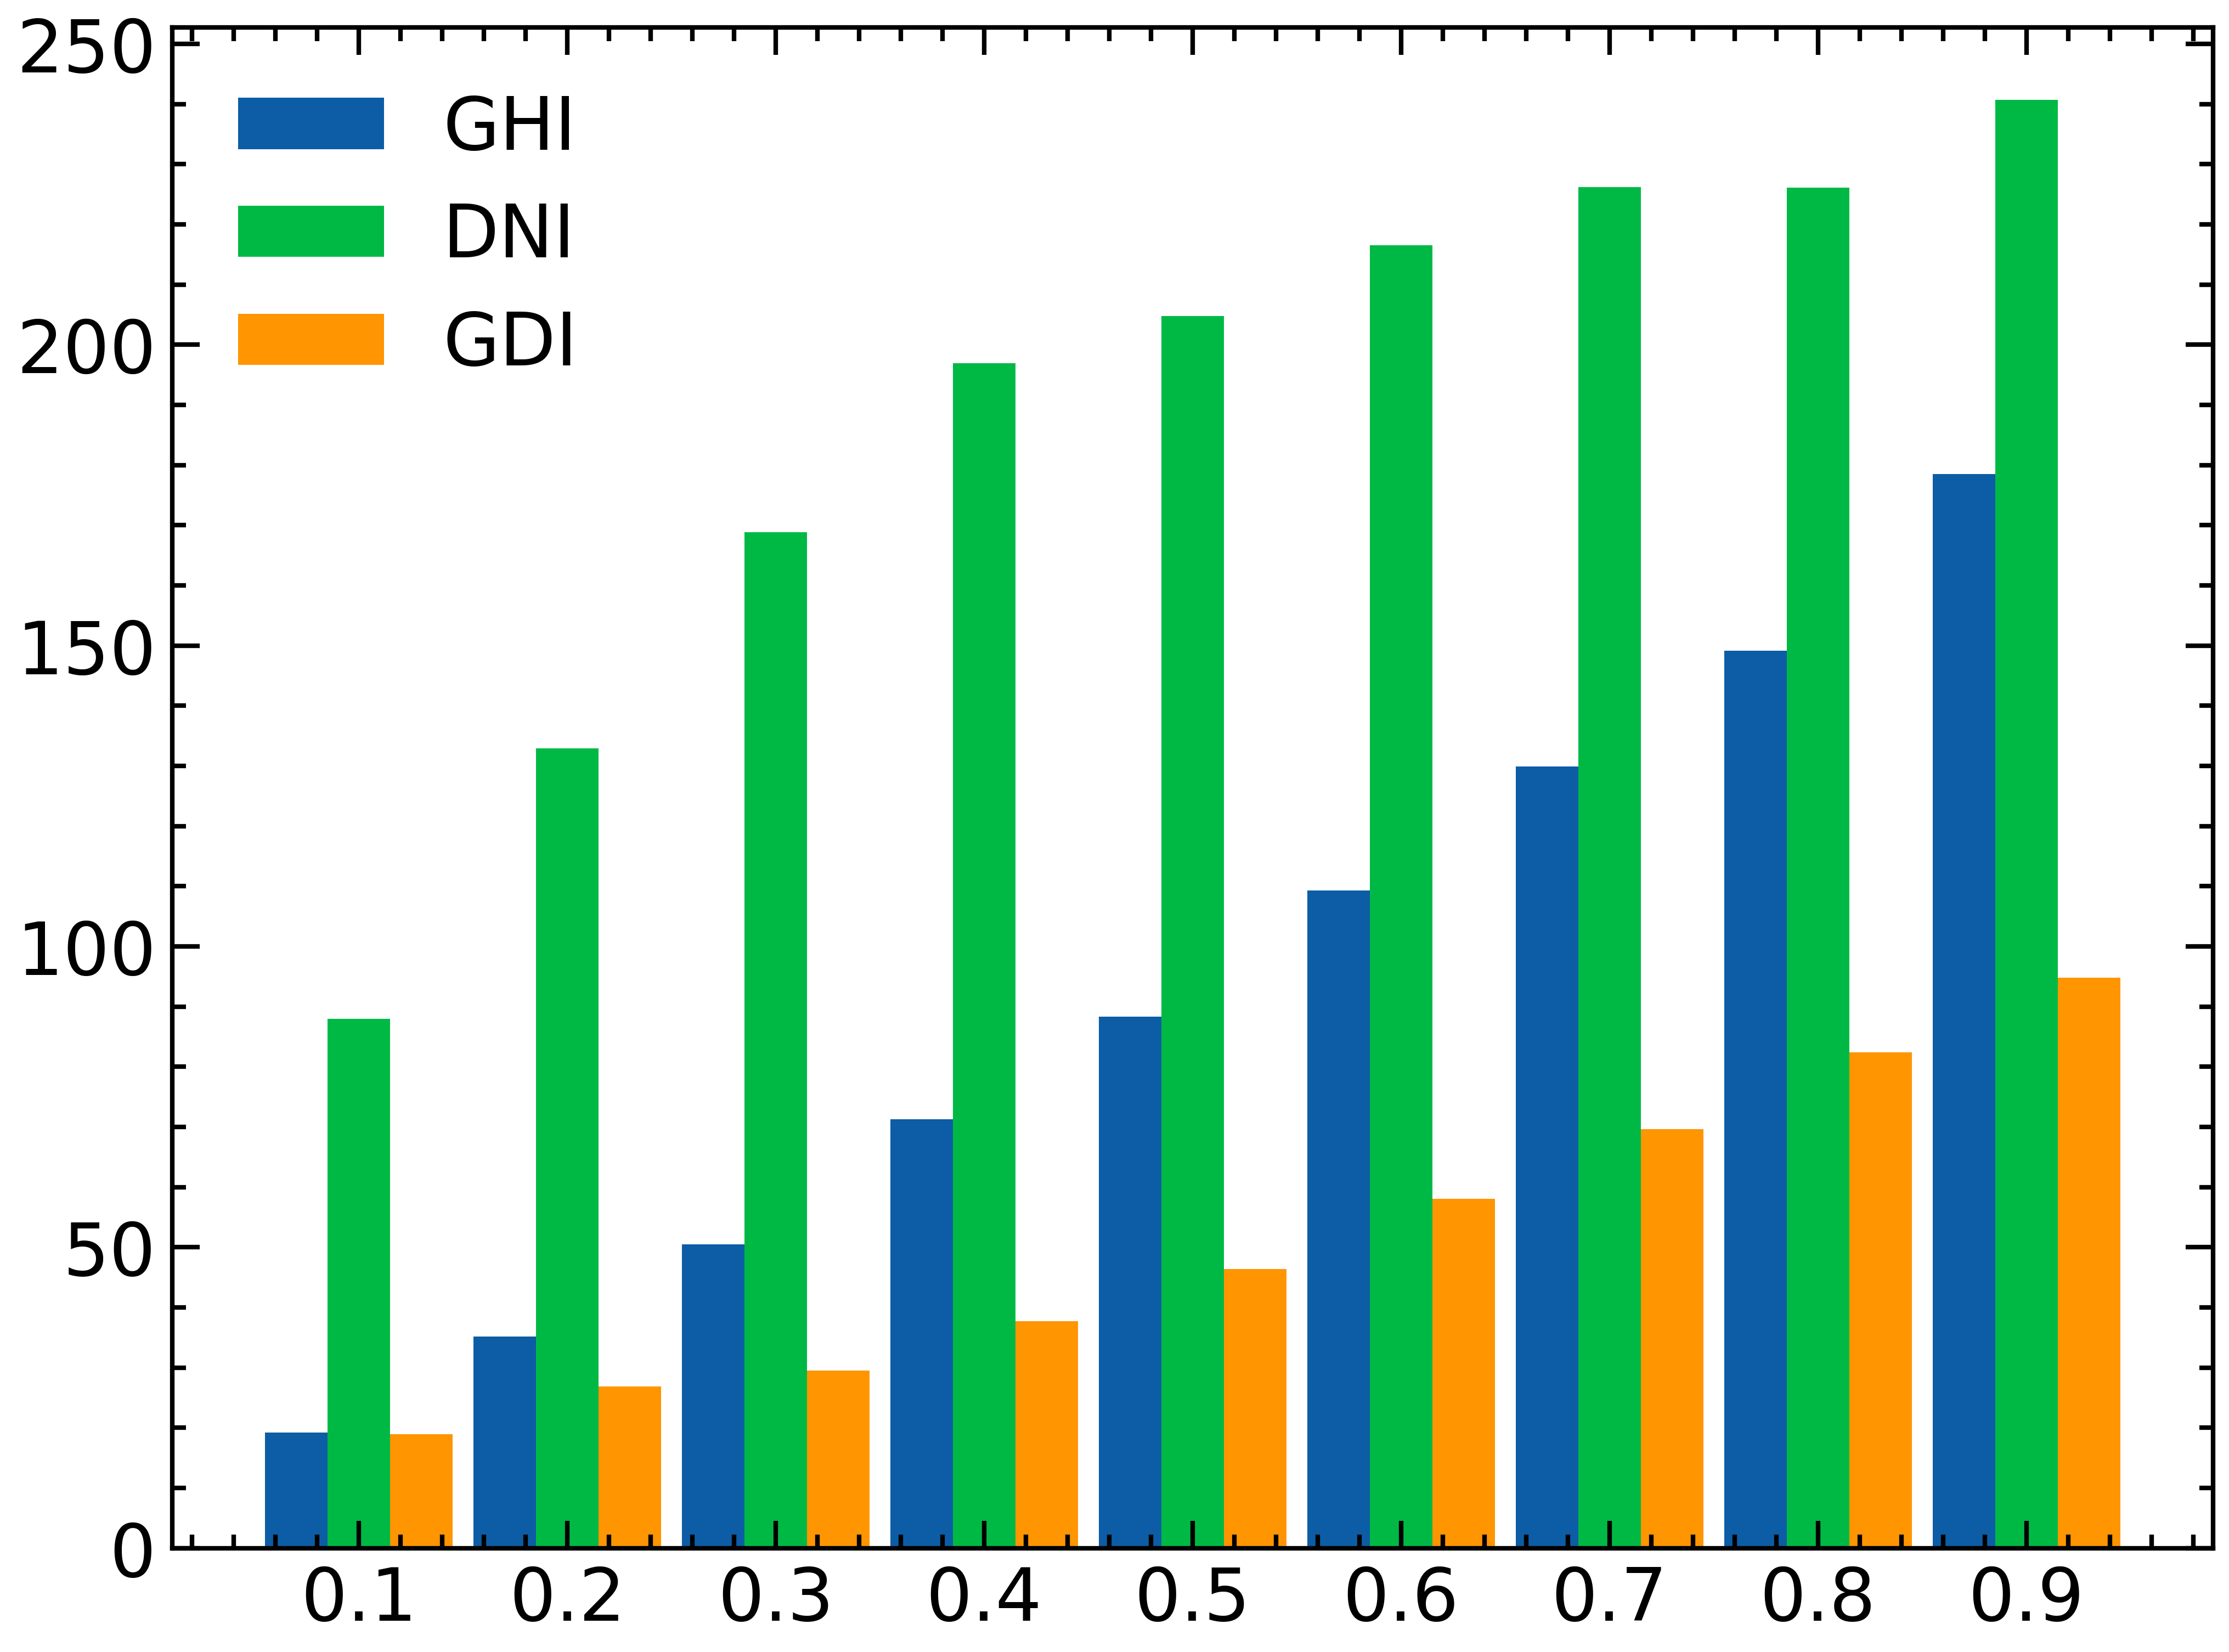

In [91]:
plt.figure()
x_axis = np.arange(len(rmse_df.index))
plt.bar(x_axis-0.3, abs(rmse_df["downward_surface_SW_flux_rmse"]), 0.3, label = "GHI")
plt.bar(x_axis, abs(rmse_df["direct_surface_SW_flux_rmse"]), 0.3, label = "DNI")
plt.bar(x_axis+0.3, abs(rmse_df["diffuse_surface_SW_flux_rmse"]), 0.3, label = "GDI")
plt.xticks(ticks = range(len(mean_df.index)-1), labels = [x/10 for x in range(1, 10)])


plt.legend()
plt.show()

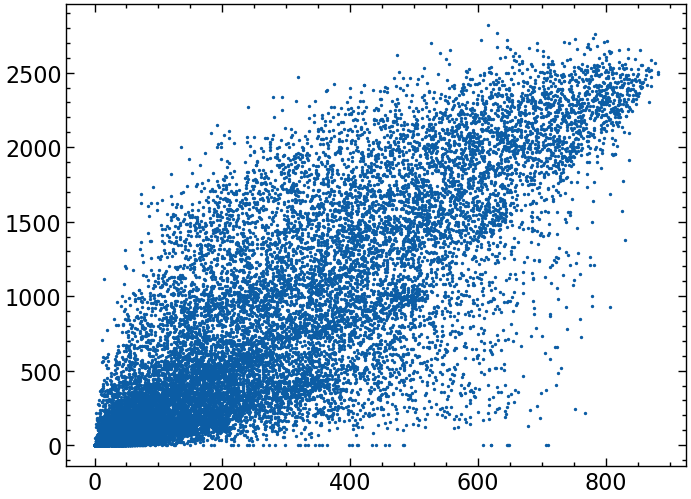

In [39]:
daytime = daytime[daytime['is_day']]
plt.scatter(daytime['downward_surface_SW_flux'], daytime['P'], s=2)